# Objective: fine-tuning DETR

-   This notebook can be found on my Github profile: https://github.com/woctezuma/finetune-detr
-   Official DETR repository: https://github.com/facebookresearch/detr
-   Discussion about fine-tuning in [a Github issue](https://github.com/facebookresearch/detr/issues/9).
-   A nice blog post about another approach (Mask R-CNN) and the balloon dataset (which we use in this notebook): [here](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46).

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!pip install -U torch==1.7.0
!pip install -U torchvision==0.8.1 
!pip install -U torchtext==0.8.0

ERROR: Operation cancelled by user


In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

1.7.0 False


In [5]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [6]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [7]:
# COCO classes
CLASSES = ['misc_stuff', 'aac_blocks', 'adhesives', 'ahus', 'aluminium_frames_for_false_ceiling', 'chiller', 'concrete_mixer_machine', 'concrete_pump_(50%)', 'control_panel', 'cu_piping', 'distribution_transformer', 'dump_truck___tipper_truck', 'emulsion_paint', 'enamel_paint', 'fine_aggregate', 'fire_buckets', 'fire_extinguishers', 'glass_wool', 'grader', 'hoist', 'hollow_concrete_blocks', 'hot_mix_plant', 'hydra_crane', 'interlocked_switched_socket', 'junction_box', 'lime', 'marble', 'metal_primer', 'pipe_fittings', 'rcc_hume_pipes', 'refrigerant_gas', 'river_sand', 'rmc_batching_plant', 'rmu_units', 'sanitary_fixtures', 'skid_steer_loader_(bobcat)', 'smoke_detectors', 'split_units', 'structural_steel_-_channel', 'switch_boards_and_switches', 'texture_paint', 'threaded_rod', 'transit_mixer', 'vcb_panel', 'vitrified_tiles', 'vrf_units', 'water_tank', 'wheel_loader', 'wood_primer', 'banner', 'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet', 'cage', 'cardboard', 'carpet', 'ceiling-other', 'ceiling-tile', 'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain', 'desk-stuff', 'dirt', 'door-stuff', 'fence', 'floor-marble', 'floor-other', 'floor-stone', 'floor-tile', 'floor-wood', 'flower', 'fog', 'food-other', 'fruit', 'furniture-other', 'grass', 'gravel', 'ground-other', 'hill', 'house', 'leaves', 'light', 'mat', 'metal', 'mirror-stuff', 'moss', 'mountain', 'mud', 'napkin', 'net', 'paper', 'pavement', 'pillow', 'plant-other', 'plastic', 'platform', 'playingfield', 'railing', 'railroad', 'river', 'road', 'rock', 'roof', 'rug', 'salad', 'sand', 'sea', 'shelf', 'sky-other', 'skyscraper', 'snow', 'solid-other', 'stairs', 'stone', 'straw', 'structural-other', 'table', 'tent', 'textile-other', 'towel', 'tree', 'vegetable', 'wall-brick', 'wall-concrete', 'wall-other', 'wall-panel', 'wall-stone', 'wall-tile', 'wall-wood', 'water-other', 'waterdrops', 'window-blind', 'window-other', 'wood', 'other', 'tree-merged', 'fence-merged', 'ceiling-merged','sky-other-merged','cabinet-merged','table-merged','floor-other-merged','pavement-merged','mountain-merged', 'grass-merged', 'dirt-merged', 'paper-merged', 'food-other-merged', 'building-other-merged', 'rock-merged', 'wall-other-merged', 'rug-merged']

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [8]:
len(CLASSES)

158

In [9]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Load an image for a demo

In [10]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [12]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

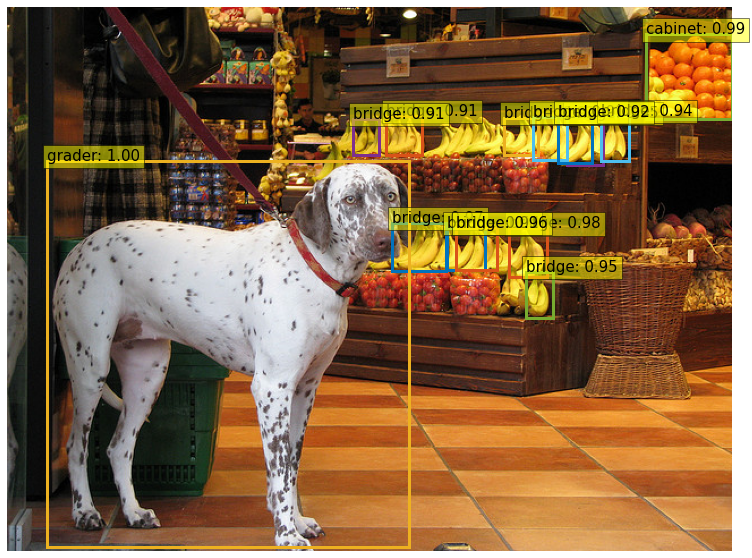

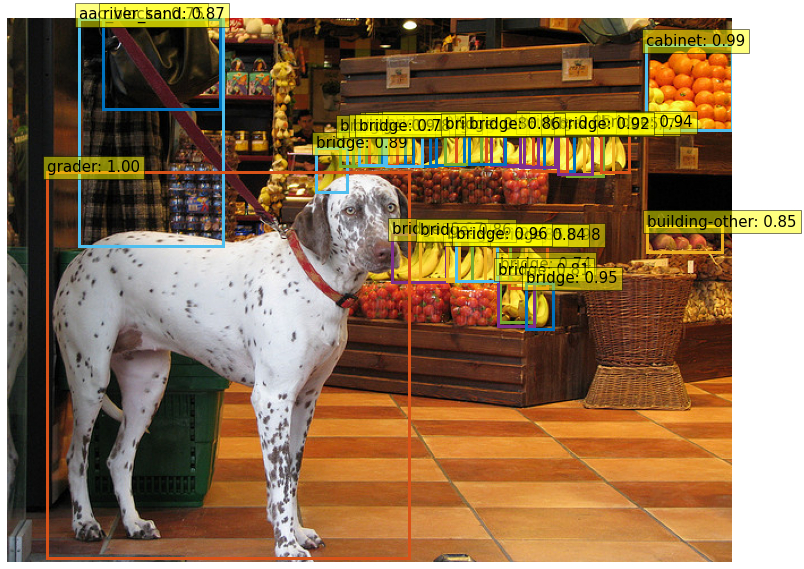

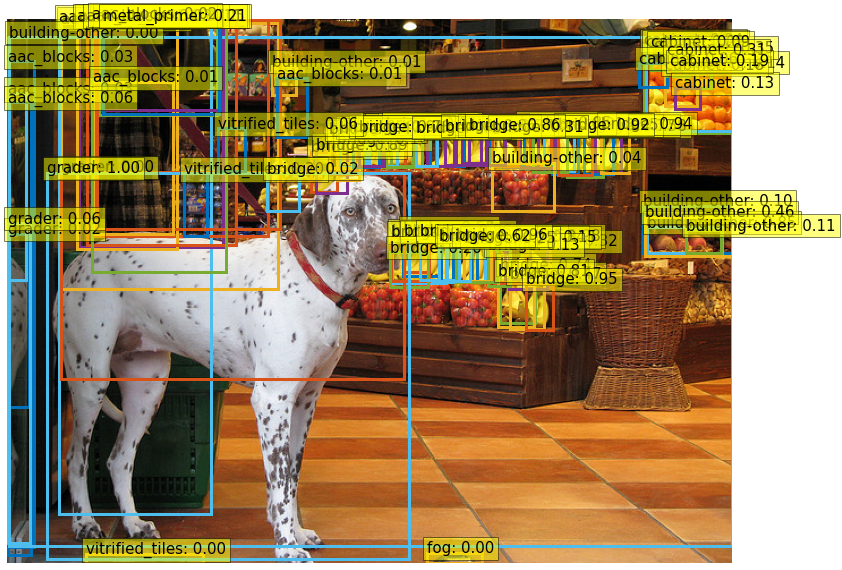

In [13]:
for threshold in [0.9, 0.7, 0.0]:
  
  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                            threshold=threshold)

  plot_results(im, probas_to_keep, bboxes_scaled)

NB: if the threshold is equal to zero, then you will see all of the 100 query slots. The zero-threshold is only used for illustration. In usual cases, most query slots have a low confidence score, so that irrelevant query slots would be pruned with a higher threshold, such as 0.7 or 0.9.

Reference: https://github.com/facebookresearch/detr/issues/9#issuecomment-635357693

NB²: For fine-tuning purposes, we cannot change the number of query slots.

> If you're fine-tuning, I don't recommend changing the number of queries on the fly, it is extremely unlikely to work out of the box. In this case you're probably better off retraining from scratch (you can change the --num_queries arg from our training script).

Reference: https://github.com/facebookresearch/detr/issues/9#issuecomment-636407752

## Clone my custom code of DETR

Clone [my fork](https://github.com/woctezuma/detr/tree/finetune) tailored for a custom dataset:
-   called `custom`,
-   with `max_class_id = 2` ([explanation](https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223)).

**Caveat**: if you later use `first_class_index = 1` for your dataset, then it is fine. However, if you later use `first_class_index = 0`, then you will have to override the value of `max_class_id` (so that it is equal to 1) when calling `!python main.py`. My fork can do that.


In [14]:
%cd /content/

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

/content
Cloning into 'detr'...
remote: Enumerating objects: 239, done.
remote: Total 239 (delta 0), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (239/239), 284.61 KiB | 5.08 MiB/s, done.
Resolving deltas: 100% (131/131), done.
/content/detr
Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.
Switched to a new branch 'finetune'


## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [15]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

## Prepare the dataset for fine-tuning

The `balloon` dataset will be used. It is featured here and uses VIA format:
-   https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon


You can choose whether to start indexing categories with 0 or with 1.

This is a matter of taste, and it should not impact the performance of the algorithm.

In [16]:
# Choose whether to start indexing categories with 0 or with 1.
#
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
#
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 0

Clone [my fork](https://github.com/woctezuma/VIA2COCO/tree/fixes) to convert annotations from VIA format to COCO format.

We expect the directory structure to be the following:
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

## Check the dataset after it was pre-processed for fine-tuning

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:
-   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [26]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [28]:
dataDir='/content/drive/MyDrive/datanew/custom/'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)

In [29]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!


In [30]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['misc_stuff', 'aac_blocks', 'adhesives', 'ahus', 'aluminium_frames_for_false_ceiling', 'chiller', 'concrete_mixer_machine', 'concrete_pump_(50%)', 'control_panel', 'cu_piping', 'distribution_transformer', 'dump_truck___tipper_truck', 'emulsion_paint', 'enamel_paint', 'fine_aggregate', 'fire_buckets', 'fire_extinguishers', 'glass_wool', 'grader', 'hoist', 'hollow_concrete_blocks', 'hot_mix_plant', 'hydra_crane', 'interlocked_switched_socket', 'junction_box', 'lime', 'marble', 'metal_primer', 'pipe_fittings', 'rcc_hume_pipes', 'refrigerant_gas', 'river_sand', 'rmc_batching_plant', 'rmu_units', 'sanitary_fixtures', 'skid_steer_loader_(bobcat)', 'smoke_detectors', 'split_units', 'structural_steel_-_channel', 'switch_boards_and_switches', 'texture_paint', 'threaded_rod', 'transit_mixer', 'vcb_panel', 'vitrified_tiles', 'vrf_units', 'water_tank', 'wheel_loader', 'wood_primer', 'banner', 'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet', 'cage', 'cardboard', 'car

In [31]:
# load and display image
catIds = coco.getCatIds(catNms=['aluminium_frames_for_false_ceiling']);
imgIds = coco.getImgIds(catIds=catIds );

## Fine-tuning

-   Instructions appear in [a Github Gist](https://gist.github.com/woctezuma/e9f8f9fe1737987351582e9441c46b5d).

NB: There is a `--frozen_weights` argument. However,
i) I have yet to figure out how it is used,
ii) it is of no use for box detection. Indeed, "frozen training is meant for segmentation only" (as mentioned at this [line](https://github.com/facebookresearch/detr/blob/f4cdc542de34de771da8b9189742e5465f5220cd/main.py#L110) of the source-code).

### Boilerplate variables

**Caveat**: the parameter name `num_classes` is misleading. It is actually the ID which DETR will reserve for **its own** `no_object` class.

It should be set to one plus the highest class ID in your dataset.

For instance, if you have one class (balloon):
- if you used the index n°0 for this class, then `max_id = 0` and `num_classes = max_id+1 = 1`
- if you used the index n°1 for this class, then `max_id = 1` and `num_classes = max_id+1 = 2`

Reference: https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223

In [29]:
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.

  num_classes = 80

  finetuned_classes = CLASSES

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.  

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 81

  finetuned_classes = ['N/A'] + CLASSES

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 80
Fine-tuned classes: ['misc_stuff', 'aac_blocks', 'adhesives', 'ahus', 'aluminium_frames_for_false_ceiling', 'chiller', 'concrete_mixer_machine', 'concrete_pump_(50%)', 'control_panel', 'cu_piping', 'distribution_transformer', 'dump_truck___tipper_truck', 'emulsion_paint', 'enamel_paint', 'fine_aggregate', 'fire_buckets', 'fire_extinguishers', 'glass_wool', 'grader', 'hoist', 'hollow_concrete_blocks', 'hot_mix_plant', 'hydra_crane', 'interlocked_switched_socket', 'junction_box', 'lime', 'marble', 'metal_primer', 'pipe_fittings', 'rcc_hume_pipes', 'refrigerant_gas', 'river_sand', 'rmc_batching_plant', 'rmu_units', 'sanitary_fixtures', 'skid_steer_loader_(bobcat)', 'smoke_detectors', 'split_units', 'structural_steel_-_channel', 'switch_boards_and_switches', 'texture_paint', 'threaded_rod', 'transit_mixer', 'vcb_panel', 'vitrified_tiles', 'vrf_units', 'water_tank', 'wheel_loader', 'wood_primer', 'banner', 'blanket', 'branch', 'bridge', 'buildi

In [37]:
%cd /content/detr/

/content/detr


**Caveat**: below, we override the value of `num_classes` (hard-coded to 2 for the `custom` dataset in my `finetune` branch of DETR) in case `first_class_index = 0` instead of `first_class_index = 1` (default value).

In [19]:
 python main.py \
  --masks \
  --dataset_file "coco_panoptic" \
  --coco_path "/content/drive/MyDrive/datanew/custom" \
  --coco_panoptic_path "/content/drive/MyDrive/datanew/custom" \
  --output_dir "/content/drive/MyDrive/datanew/outputdir/outpanoptic" \
  --frozen_weights "/content/drive/MyDrive/datanew/custom/outputdir/checkpoint_57_epoch.pth" \
  --num_classes $num_classes \
  --epochs 50 \
  --lr 1e-5 \
  --lr_drop 1000 \
  --num_queries 60 \
  --batch_size 1

Not using distributed mode
git:
  sha: e42a3b174d2325c28f82d7114138c755ac7c095a, status: clean, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=4, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/content/drive/MyDrive/datanew/custom/', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=26, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=158, num_queries=100, num_workers=2, output_dir='/content/drive/MyDrive/datanew/outputdir/outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='/content/drive/MyDrive/datanew/outputdir/outputs/checkpoint.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)